# Stock Price Prediction

### Data exploration

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 8)

In [12]:
df = pd.read_csv('Data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18651 entries, 0 to 18650
Data columns (total 12 columns):
Date              18651 non-null object
Bid_Price         18651 non-null float64
Bid_Shares        18651 non-null int64
Ask_Price         18651 non-null float64
Ask_Shares        18651 non-null int64
FeaturePrice1     18651 non-null float64
FeaturePrice2     18651 non-null float64
FeaturePrice3     18651 non-null float64
FeaturePrice4     18651 non-null float64
FeatureShares1    18651 non-null int64
FeatureShares2    18651 non-null int64
TargetPrice       18651 non-null float64
dtypes: float64(7), int64(4), object(1)
memory usage: 1.7+ MB


,Date,Bid_Price,Bid_Shares,Ask_Price,Ask_Shares,FeaturePrice1,FeaturePrice2,FeaturePrice3,FeaturePrice4,FeatureShares1,FeatureShares2,TargetPrice
0,2016-04-14,111.58,35,111.59,300,111.59,111.62,111.63,112.04,263236,22556,111.64
1,2016-04-14,5.10,100,5.25,100,5.11,5.11,5.11,5.09,2895,-94,5.10
2,2016-04-14,12.80,500,138.80,100,13.73,13.41,13.41,13.88,3403,-6597,13.51
3,2016-04-14,58.38,250,59.10,3600,59.10,59.19,59.20,59.80,13935,16246,59.23
4,2016-04-14,43.88,500,43.99,500,44.00,44.03,44.03,43.92,185,2215,44.03


### Feature Selection 

Узнаем, есть ли связь между данными признаками и целевой переменной TargetPrice. 

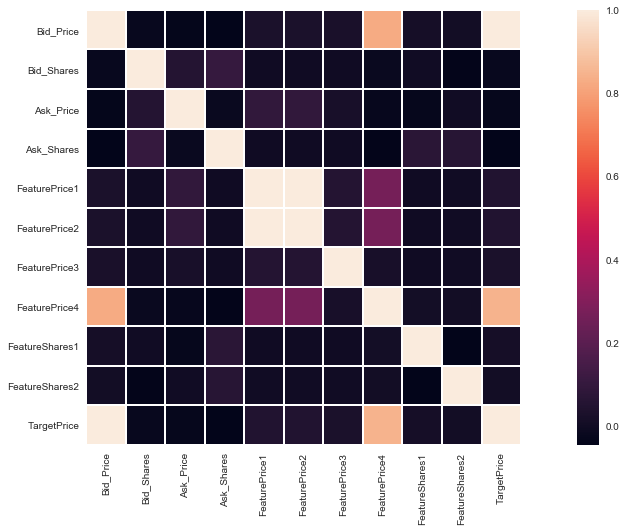

In [13]:
sns.heatmap(df.corr(), square=True, linewidths=1)

Существенно кореллируют с TargetPrice лишь Bid_Price и FeaturePrice4. С ними и будем работать.

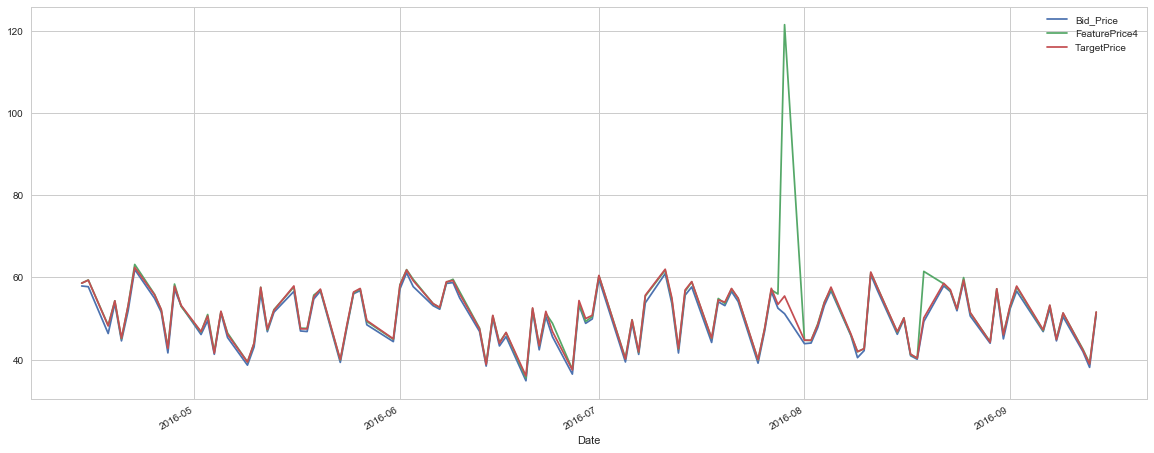

In [14]:
df['Date'] = df.Date.astype('datetime64[ns]')
df.groupby('Date')['Bid_Price', 'FeaturePrice4', 'TargetPrice'].mean().plot(kind='line')

### Data Preparation

In [15]:
from sklearn.preprocessing import MinMaxScaler


def scale(df, cols):
    df = df[cols]
    x = df.values
    cols = list(df.columns.values)
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    df.columns = cols
    return df

Разделим и нормализуем данные из Data.csv.
Нормализация происходит после разделения, поскольку в соответствии с примечанием
к заданию, выборка должна быть поделена по дням, а не строкам. Таким образом, сначала 
были сформированы массивы из записей одной даты, после этого "перемешаны", разделены, 
и снова преобразованы в 2 дата-фрейма. 
Это невозможно сделать без колонки дат, а нормализовать ее не нужно.

In [16]:
df = df[['Date', 'Bid_Price', 'FeaturePrice4', 'TargetPrice']]
dfs = [row for date, row in df.groupby('Date')]
np.random.shuffle(dfs)
point = int(len(dfs) * 0.7)

Xy_train = pd.concat(dfs[:point])
Xy_test = pd.concat(dfs[point:])

X_MIN, X_MAX = df['TargetPrice'].min(), df['TargetPrice'].max()

X_train = scale(Xy_train, ['Bid_Price', 'FeaturePrice4'])
y_train = scale(Xy_train, ['TargetPrice'])
X_test = scale(Xy_test, ['Bid_Price', 'FeaturePrice4'])
y_test = scale(Xy_test, ['TargetPrice'])

### Machine Learning

В качестве моделей будем использовать линейную регрессию, так как она хорошо отражает
линейные зависимости между переменными, также протестируем нейронную сеть, а именно
однослойный перцептрон с одним скрытым слоем.

In [17]:
from sklearn.linear_model import LinearRegression


reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.90346221054058884

In [18]:
from sklearn.neural_network import MLPRegressor


mlp = MLPRegressor(
    alpha=0.001, 
    hidden_layer_sizes = (20), 
    activation = 'logistic',
    learning_rate = 'adaptive')
    
mlp.fit(X_train, y_train.values.ravel())
mlp.score(X_test, y_test.values.ravel())

0.9695775347790917

Обе модели были оценены по критерию R^2. 
Спрогнозируем с их помощью TargetPrice из Test.csv.

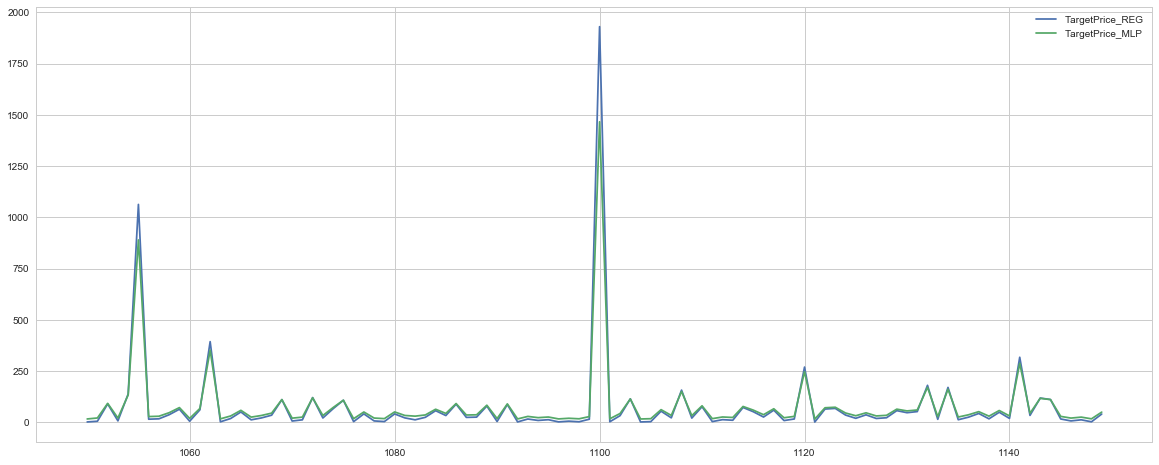

In [19]:
df_control = pd.read_csv('Test.csv')

df_control = scale(df_control, ['Bid_Price', 'FeaturePrice4'])
df_temp = df_control.copy()
df_control['TargetPrice_REG'], df_control['TargetPrice_MLP']  = reg.predict(df_temp), mlp.predict(df_temp)
df_control = df_control * (X_MAX - X_MIN) + X_MIN 
df_control[1050:1150][['TargetPrice_REG', 'TargetPrice_MLP']].plot()